# Source Layouts


We will compare different source layouts for gridding potential field data throught the Equivalent Layer method.
Lets define three layouts of point sources:

1. **Source beneath data**: One source point beneath each data point
2. **Block reduced sources**: Block reduce the observation points and put one source point beneath the reduced coordinate for each block
3. **Grid of sources**: A regular grid of source points

Moreover, the depth of the sources can be chosen by different ways. Here we will try the following:

1. **Constant depth**: Source points located all at the same depth, which can be computed as the mean height of the data points minus a constant depth.
2. **Relative depth**: Source points located at a constant relative depth bellow the data points. If the data points are not at the same height (which is the usual case), the point sources will be located at different depths, but at the same relative depth from its corresponding data point -or block reduced data point.
3. **Variable relative depth**: Source points located at a variable relative depth from the data points. We can define a relative depth for each source point as a quantity proportional to the median distance to its k nearest source points. Also, this relative depth can be static shifted by a constant depth in order to avoid very shallow sources in case of too close source points.

The first two layouts can be setted with any of these three types of depth, although the grid of sources can only be defined with the constant depth.
Therefore we get a total of 7 possible combinations of layouts and depths:

|    | Constant depth | Relative depth | Variable relative depth |
| -- |----------------|----------------|-------------------------|
| **Source beneath data** | ✅ | ✅ | ✅ |
| **Block reduced sources** | ✅ | ✅ | ✅ |
| **Grid of sources** | ✅ | ❌ | ❌ |


Here we will show some examples on how each source layout look like for the same data set.


**Import useful packages**

In [1]:
import pyproj
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt

from eql_source_layouts import (
    source_bellow_data,
    block_reduced_sources,
    grid_sources,
)

**Define parameters for building the source layouts**

In [2]:
# Define dictionaries where the source layouts will be stored
constant_depth_layouts = {}
relative_depth_layouts = {}
variable_relative_depth_layouts = {}

# Define a region for the synthetic survey
region_degrees = [-0.5, 0.5, -0.5, 0.5]  # given in degrees

# Set a constant depth of 2km
constant_depth = 2000

# Set a relative depth of 2km
relative_depth = 2000

# Define a block size of 2km for block reduced layouts
spacing = 4000

# Define set of parameters for each source layout
# ... for constant depth
depth_type = "constant_depth"
constant_depth_params = {
    "source_beneath_data": {
        "depth_type": depth_type,
        "constant_depth": constant_depth,
    },
    "block_reduced": {
        "depth_type": depth_type,
        "spacing": spacing,
        "constant_depth": constant_depth,
    },
    "grid": {
        "spacing": spacing,
        "constant_depth": constant_depth,
    },
}

# ... for relative depth
depth_type = "relative_depth"
relative_depth_params = {
    "source_beneath_data": {
        "depth_type": depth_type,
        "relative_depth": relative_depth
    },
    "block_reduced": {
        "depth_type": depth_type,
        "spacing": spacing,
        "relative_depth": relative_depth,
    },
}


# ... for variable relative depth
depth_type = "variable_relative_depth"
variable_relative_depth_params = {
    "source_beneath_data": {
        "depth_type": depth_type,
        "depth_factor": 0.5,
        "depth_shift": -500,
        "k_nearest": 15,
    },
    "block_reduced": {
        "depth_type": depth_type,
        "depth_factor": 0.2,
        "depth_shift": -500,
        "k_nearest": 2,
        "spacing": spacing,
    }
}

**Define function to plot multiple layouts**

In [3]:
def plot_layouts(layouts, s=40):
    """
    Plot multiple source layouts as scatter points sharing colorbar
    """
    elevations = tuple(p[2] for p in layouts.values())
    vmin = np.min([e.min() for e in elevations])
    vmax = np.max([e.max() for e in elevations])
    
    n_plots = len(layouts)
    fig, axes = plt.subplots(
        figsize=(6, 4 * n_plots),
        nrows=n_plots,
        ncols=1,
        sharex=True,
        sharey=True,
    )
    for ax, layout in zip(axes, layouts):
        points = layouts[layout]
        tmp = ax.scatter(
            *points[:2], c=points[2], s=s, vmin=vmin, vmax=vmax
        )
        ax.set_title("{} (n_points: {})".format(
            layout, points[0].size)
        )
        ax.set_aspect("equal")
        plt.colorbar(tmp, ax=ax, label="m")
    plt.tight_layout()
    plt.show()

## 1. Create a synthetic airborne survey


Get coordinates of observation points from a synthetic airborne survey

In [4]:
survey = hm.synthetic.airborne_survey(region=region_degrees)
display(survey)

,longitude,latitude,height
140691,-0.496429,0.497339,633.0
140692,-0.495559,0.497999,644.0
140693,-0.493218,0.497479,646.0
140694,-0.482725,0.497679,663.0
140695,-0.478464,0.497719,672.0
...,...,...,...
383610,-0.416257,0.155824,1070.0
383611,-0.258422,0.271476,1087.0
383612,-0.258652,0.277958,1126.0
383613,-0.258983,0.287360,1106.0


Project survey points into Cartesian coordinates

In [5]:
projection = pyproj.Proj(proj="merc", lat_ts=0)
survey["easting"], survey["northing"] = projection(
    survey.longitude.values, survey.latitude.values
)
display(survey)

# Define region boundaries in projected coordinates
region = (
    survey.easting.values.min(),
    survey.easting.values.max(),
    survey.northing.min(),
    survey.northing.max(),
)

,longitude,latitude,height,easting,northing
140691,-0.496429,0.497339,633.0,-55262.223508,54993.627800
140692,-0.495559,0.497999,644.0,-55165.348426,55066.630053
140693,-0.493218,0.497479,646.0,-54904.787861,55009.113126
140694,-0.482725,0.497679,663.0,-53736.719343,55031.235020
140695,-0.478464,0.497719,672.0,-53262.365493,55035.659399
...,...,...,...,...,...
383610,-0.416257,0.155824,1070.0,-46337.467390,17230.106636
383611,-0.258422,0.271476,1087.0,-28767.445331,30018.377395
383612,-0.258652,0.277958,1126.0,-28793.055985,30735.107734
383613,-0.258983,0.287360,1106.0,-28829.801706,31774.809862


Plot the survey points

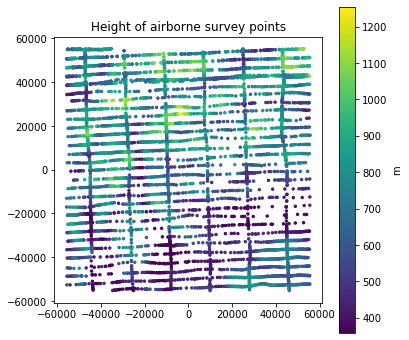

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=survey.height, s=6)
plt.colorbar(tmp, ax=ax, label="m")
ax.set_aspect("equal")
ax.set_title("Height of airborne survey points")
plt.show()

Define coordinates tuple and the projected region

In [7]:
coordinates = (survey.easting, survey.northing, survey.height)
region = vd.get_region(coordinates)

Plot the observed magnetic data

## 2. Source layouts with constant depth

We will create the three possible layouts with constant depth.
Then we will plot all the layouts to show their differences.

**1. Source beneath data**

Let's put one source point beneath each data point at a constant relative depth from the elevation of the data point:

In [8]:
layout = "source_beneath_data"
points = source_bellow_data(coordinates, **constant_depth_params[layout])
constant_depth_layouts[layout] = points

**2. Block reduced sources**

Let's put one source point beneath the block reduced data points at a constant relative depth from the reduced elevation of the data points: 

In [9]:
layout = "block_reduced"
points = block_reduced_sources(coordinates, **constant_depth_params[layout])
constant_depth_layouts[layout] = points

**3. Grid of sources**

Let's create a regular grid of source points located at a constant depth under the mean height of data points. This can easily be done by block splitting the region of the data points and putting one source point beneath each block (considering every block, not just the ones that are populated).

In [10]:
layout = "grid"
points = grid_sources(coordinates, **constant_depth_params[layout])
constant_depth_layouts[layout] = points

### Plot source layouts

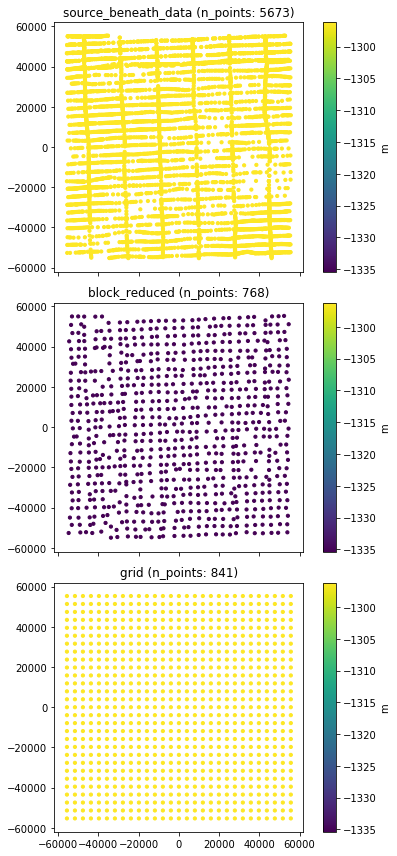

In [11]:
plot_layouts(constant_depth_layouts, s=10)

## 3. Source layouts with relative depth

We will create the possible layouts with relative depth.
Then we will plot all the layouts to show their differences.

**1. Source beneath data**

Let's put one source point beneath each data point at a constant relative depth from the elevation of the data point:

In [12]:
layout = "source_beneath_data"
points = source_bellow_data(coordinates, **relative_depth_params[layout])
relative_depth_layouts[layout] = points

**2. Block reduced sources**

Let's put one source point beneath the block reduced data points at a constant relative depth from the reduced elevation of the data points: 

In [13]:
layout = "block_reduced"
points = block_reduced_sources(coordinates, **relative_depth_params[layout])
relative_depth_layouts[layout] = points

### Plot source layouts

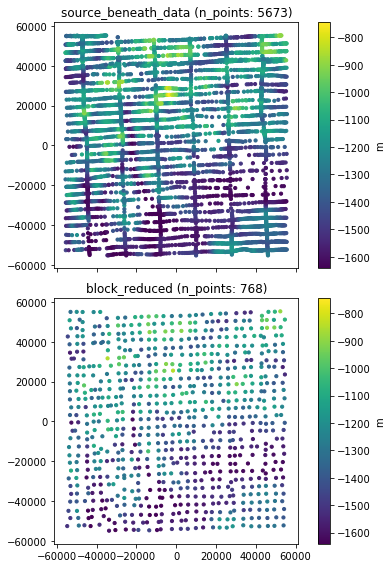

In [14]:
plot_layouts(relative_depth_layouts, s=10)

## 4. Source layouts for variable relative depth

We will create the three possible layouts with constant depth.
Then we will plot all the layouts to show their differences.

**1. One source beneath each data point**

Let's put one source point beneath each data point at an variable relative depth:

In [15]:
layout = "source_beneath_data"
points = source_bellow_data(coordinates, **variable_relative_depth_params[layout])
variable_relative_depth_layouts[layout] = points

**2. One source beneath the block reduced data points**

Let's put one source point beneath the block reduced data points at a variable relative depth:

In [16]:
layout = "block_reduced"
points = block_reduced_sources(coordinates, **variable_relative_depth_params[layout])
variable_relative_depth_layouts[layout] = points

### Plot sources layouts with variable relative depth

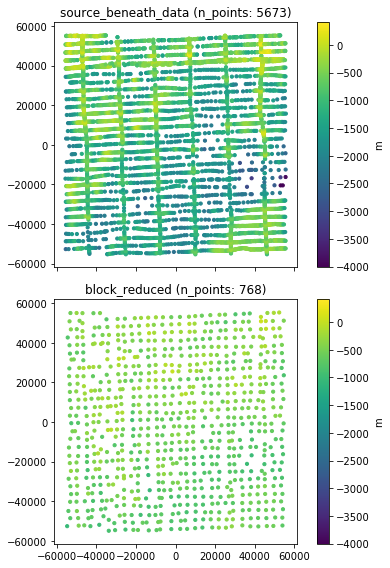

In [17]:
plot_layouts(variable_relative_depth_layouts, s=10)